In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)

In [2]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

# Merged File Analysis

In [4]:
## Import data
df_first_half_discovery = pd.read_csv("../../data/processed/02.discovery_stringency_comparison/first_half_annotation_loose.tsv",
                                     sep="\t")

df_second_half_discovery = pd.read_csv("../../data/processed/02.discovery_stringency_comparison/second_half_annotation_loose.tsv",
                                     sep="\t")

In [5]:
## Count number of annotated and novel transcripts at each threshold for each sample as a sanity check

# 20 bp threshold
print("\n\nOverlapping gene discovery at 20bp threshold for first half is:", 
      df_first_half_discovery.loc[df_first_half_discovery["20_bp_thresh"] == "ANNOTATED"].shape[0])

print("\nOverlapping gene discovery at 20bp threshold for second half is:", 
      df_second_half_discovery.loc[df_second_half_discovery["20_bp_thresh"] == "ANNOTATED"].shape[0])


## 100 bp threshold
print("\n\nOverlapping gene discovery at 100bp threshold for first half is:", 
      df_first_half_discovery.loc[df_first_half_discovery["100_bp_thresh"] == "ANNOTATED"].shape[0])

print("\nOverlapping gene discovery at 100bp threshold for second half is:", 
      df_second_half_discovery.loc[df_second_half_discovery["100_bp_thresh"] == "ANNOTATED"].shape[0])


## 200 bp threshold
print("\n\nOverlapping gene discovery at 200bp threshold for first half is:", 
      df_first_half_discovery.loc[df_first_half_discovery["200_bp_thresh"] == "ANNOTATED"].shape[0])

print("\nOverlapping gene discovery at 200bp threshold for second half is:", 
      df_second_half_discovery.loc[df_second_half_discovery["200_bp_thresh"] == "ANNOTATED"].shape[0])


## Total number of novel transcript/genes in each file
print("\n\nTotal number of discovered genes/transcript in first half:", df_first_half_discovery.shape[0])

print("\nTotal number of discovered genes/transcript in second half:", df_second_half_discovery.shape[0])



Overlapping gene discovery at 20bp threshold for first half is: 6857

Overlapping gene discovery at 20bp threshold for second half is: 6886


Overlapping gene discovery at 100bp threshold for first half is: 9357

Overlapping gene discovery at 100bp threshold for second half is: 9451


Overlapping gene discovery at 200bp threshold for first half is: 11648

Overlapping gene discovery at 200bp threshold for second half is: 11735


Total number of discovered genes/transcript in first half: 46409

Total number of discovered genes/transcript in second half: 46646


In [6]:
## Read NDR data

df_first_half_ndr = pd.read_csv("../../data/processed/02.discovery_stringency_comparison/merged_first_half_loose.tsv",
                                sep="\t", names=["transcript_id", "gene_id", "read_count", "NDR"],
                                usecols=[0, 1, 4, 5], header=0)

df_second_half_ndr = pd.read_csv("../../data/processed/02.discovery_stringency_comparison/merged_second_half_loose.tsv",
                                 sep="\t", names=["transcript_id", "gene_id", "read_count", "NDR"],
                                usecols=[0, 1, 4, 5], header=0)

In [7]:
df_first_half_ndr.head()

,transcript_id,gene_id,read_count,NDR
0,tx.1,ENSG00000227232,19,0.296452
1,tx.2,ENSG00000227232,28,0.204309
2,tx.3,ENSG00000241860,13,0.287797
3,tx.4,gene.2159,3,0.377111
4,tx.5,ENSG00000279457,37,0.224737


In [8]:
df_first_half_discovery.head()

,seqname,strand,gene_id,transcript_id,start,end,exons,20_bp_thresh,100_bp_thresh,200_bp_thresh
0,1,-,ENSG00000227232,tx.1,14400,16307,3,NOVEL,NOVEL,ANNOTATED
1,1,-,ENSG00000227232,tx.2,14402,15113,2,ANNOTATED,ANNOTATED,ANNOTATED
2,1,-,ENSG00000241860,tx.29002,164741,181155,7,NOVEL,NOVEL,NOVEL
3,1,-,ENSG00000241860,tx.16365,167117,181201,6,ANNOTATED,ANNOTATED,ANNOTATED
4,1,-,ENSG00000241860,tx.3,177297,181141,3,NOVEL,NOVEL,NOVEL


In [9]:
df_first_half = pd.merge(df_first_half_discovery[["transcript_id", "20_bp_thresh"]], df_first_half_ndr, how="inner", 
                        on="transcript_id")

df_second_half = pd.merge(df_second_half_discovery[["transcript_id", "20_bp_thresh"]], df_second_half_ndr, how="inner", 
                        on="transcript_id")

In [10]:
## Improve name of variables

df_first_half.loc[df_first_half["20_bp_thresh"] == "ANNOTATED", "20_bp_thresh"] = "Overlaping"
df_first_half.loc[df_first_half["20_bp_thresh"] == "NOVEL", "20_bp_thresh"] = "Divergent"

df_second_half.loc[df_second_half["20_bp_thresh"] == "ANNOTATED", "20_bp_thresh"] = "Overlaping"
df_second_half.loc[df_second_half["20_bp_thresh"] == "NOVEL", "20_bp_thresh"] = "Divergent"

In [11]:
## Get percent overlap for each NDR threshold

list_ndr_2 = []
list_prop_overlap = []
list_prop_overlap_gene = []
list_prop_overlap_transcript = []

for i in range(100, 0, -1):
    
    j = i/100
    
    df_first = df_first_half.loc[df_first_half["NDR"] <= j].copy()
    df_second = df_second_half.loc[df_second_half["NDR"] <= j].copy()
    
    df_first_gene = df_first.loc[df_first["gene_id"].str.contains("gene.")].copy()
    df_first_transcripts = df_first.loc[~df_first["gene_id"].str.contains("gene.")].copy()
    
    df_second_gene = df_second.loc[df_second["gene_id"].str.contains("gene.")].copy()
    df_second_transcripts = df_second.loc[~df_second["gene_id"].str.contains("gene.")].copy()
    
    first_overlapping = df_first.loc[df_first["20_bp_thresh"] == "Overlaping"].shape[0]/df_first.shape[0]
    second_overlapping = df_second.loc[df_second["20_bp_thresh"] == "Overlaping"].shape[0]/df_second.shape[0]
    
    first_prop_overlapping_gene = df_first_gene.loc[df_first_gene["20_bp_thresh"] == "Overlaping"].shape[0]/df_first_gene.shape[0]
    second_prop_overlapping_gene = df_second_gene.loc[df_second_gene["20_bp_thresh"] == "Overlaping"].shape[0]/df_second_gene.shape[0]

    first_prop_overlapping_transcript = df_first_transcripts.loc[df_first_transcripts["20_bp_thresh"] == "Overlaping"].shape[0]/df_first_transcripts.shape[0]
    second_prop_overlapping_transcript = df_second_transcripts.loc[df_second_transcripts["20_bp_thresh"] == "Overlaping"].shape[0]/df_second_transcripts.shape[0]
    
    overlap_pro= round(((first_overlapping + second_overlapping)/2), 3)
    overlap_pro_gene = round(((first_prop_overlapping_gene + second_prop_overlapping_gene)/2), 3)
    overlap_pro_transcript = round(((first_prop_overlapping_transcript + second_prop_overlapping_transcript)/2), 3)
    
    list_ndr_2.append(j)
    list_prop_overlap.append(overlap_pro)
    list_prop_overlap_gene.append(overlap_pro_gene)
    list_prop_overlap_transcript.append(overlap_pro_transcript)

# UKY vs CSHL File Analysis

In [12]:
## Import data
df_cshl_discovery = pd.read_csv("../../data/processed/02.discovery_stringency_comparison/cshl_annotation_loose.tsv",
                                     sep="\t", low_memory=False)

df_uky_discovery = pd.read_csv("../../data/processed/02.discovery_stringency_comparison/uky_annotation_loose.tsv",
                                     sep="\t", low_memory=False)

In [13]:
## Count number of annotated and novel transcripts at each threshold for each sample as a sanity check

# 20 bp threshold
print("\n\nOverlapping gene discovery at 20bp threshold for CSHL is:", 
      df_cshl_discovery.loc[df_cshl_discovery["20_bp_thresh"] == "ANNOTATED"].shape[0])

print("\nOverlapping gene discovery at 20bp threshold for UKY is:", 
      df_uky_discovery.loc[df_uky_discovery["20_bp_thresh"] == "ANNOTATED"].shape[0])


## 100 bp threshold
print("\n\nOverlapping gene discovery at 100bp threshold for CSHL is:", 
      df_cshl_discovery.loc[df_cshl_discovery["100_bp_thresh"] == "ANNOTATED"].shape[0])

print("\nOverlapping gene discovery at 100bp threshold for UKY is:", 
      df_uky_discovery.loc[df_uky_discovery["100_bp_thresh"] == "ANNOTATED"].shape[0])


## 200 bp threshold
print("\n\nOverlapping gene discovery at 200bp threshold for CSHL is:", 
      df_cshl_discovery.loc[df_cshl_discovery["200_bp_thresh"] == "ANNOTATED"].shape[0])

print("\nOverlapping gene discovery at 200bp threshold for UKY is:", 
      df_uky_discovery.loc[df_uky_discovery["200_bp_thresh"] == "ANNOTATED"].shape[0])


## Total number of novel transcript/genes in each file
print("\n\nTotal number of discovered genes/transcript in CSHL:", df_first_half_discovery.shape[0])

print("\nTotal number of discovered genes/transcript in UKY:", df_second_half_discovery.shape[0])



Overlapping gene discovery at 20bp threshold for CSHL is: 2268

Overlapping gene discovery at 20bp threshold for UKY is: 2670


Overlapping gene discovery at 100bp threshold for CSHL is: 4608

Overlapping gene discovery at 100bp threshold for UKY is: 5404


Overlapping gene discovery at 200bp threshold for CSHL is: 7079

Overlapping gene discovery at 200bp threshold for UKY is: 8005


Total number of discovered genes/transcript in CSHL: 46409

Total number of discovered genes/transcript in UKY: 46646


In [14]:
## Read NDR data

df_cshl_ndr = pd.read_csv("../../data/processed/02.discovery_stringency_comparison/cshl_aged_loose.tsv",
                                sep="\t", names=["transcript_id", "gene_id", "read_count", "NDR"],
                                usecols=[0, 1, 4, 5], header=0)

df_uky_ndr = pd.read_csv("../../data/processed/02.discovery_stringency_comparison/uky_aged_loose.tsv",
                                 sep="\t", names=["transcript_id", "gene_id", "read_count", "NDR"],
                                usecols=[0, 1, 4, 5], header=0)

In [15]:
df_cshl = pd.merge(df_cshl_discovery[["transcript_id", "20_bp_thresh"]], df_cshl_ndr, how="inner", 
                        on="transcript_id")

df_uky = pd.merge(df_uky_discovery[["transcript_id", "20_bp_thresh"]], df_uky_ndr, how="inner", 
                        on="transcript_id")

In [16]:
## Improve name of variables

df_cshl.loc[df_cshl["20_bp_thresh"] == "ANNOTATED", "20_bp_thresh"] = "Overlaping"
df_cshl.loc[df_cshl["20_bp_thresh"] == "NOVEL", "20_bp_thresh"] = "Divergent"

df_uky.loc[df_uky["20_bp_thresh"] == "ANNOTATED", "20_bp_thresh"] = "Overlaping"
df_uky.loc[df_uky["20_bp_thresh"] == "NOVEL", "20_bp_thresh"] = "Divergent"

In [17]:
## Get percent overlap for each NDR threshold

list_ndr_2 = []
list_prop_overlap_2 = []
list_prop_overlap_2_gene = []
list_prop_overlap_2_transcript = []

for i in range(100, 0, -1):
    
    j = i/100
    
    df_cshl_2 = df_cshl.loc[df_cshl["NDR"] <= j].copy()
    df_uky_2 = df_uky.loc[df_uky["NDR"] <= j].copy()
    
    df_cshl_2_gene = df_cshl_2.loc[df_cshl_2["gene_id"].str.contains("gene.")].copy()
    df_cshl_2_transcripts = df_cshl_2.loc[~df_cshl_2["gene_id"].str.contains("gene.")].copy()
    
    df_uky_2_gene = df_uky_2.loc[df_uky_2["gene_id"].str.contains("gene.")].copy()
    df_uky_2_transcripts = df_uky_2.loc[~df_uky_2["gene_id"].str.contains("gene.")].copy()
    
    cshl_prop_overlapping_2 = df_cshl_2.loc[df_cshl_2["20_bp_thresh"] == "Overlaping"].shape[0]/df_cshl_2.shape[0]
    uky_prop_overlapping_2 = df_uky_2.loc[df_uky_2["20_bp_thresh"] == "Overlaping"].shape[0]/df_uky_2.shape[0]
    
    cshl_prop_overlapping_2_gene = df_cshl_2_gene.loc[df_cshl_2_gene["20_bp_thresh"] == "Overlaping"].shape[0]/df_cshl_2_gene.shape[0]
    uky_prop_overlapping_2_gene = df_uky_2_gene.loc[df_uky_2_gene["20_bp_thresh"] == "Overlaping"].shape[0]/df_uky_2_gene.shape[0]

    cshl_prop_overlapping_2_transcript = df_cshl_2_transcripts.loc[df_cshl_2_transcripts["20_bp_thresh"] == "Overlaping"].shape[0]/df_cshl_2_transcripts.shape[0]
    uky_prop_overlapping_2_transcript = df_uky_2_transcripts.loc[df_uky_2_transcripts["20_bp_thresh"] == "Overlaping"].shape[0]/df_uky_2_transcripts.shape[0]
    
    overlap_pro_2 = round(((cshl_prop_overlapping_2 + uky_prop_overlapping_2)/2), 3)
    overlap_pro_2_gene = round(((cshl_prop_overlapping_2_gene + uky_prop_overlapping_2_gene)/2), 3)
    overlap_pro_2_transcript = round(((cshl_prop_overlapping_2_transcript + uky_prop_overlapping_2_transcript)/2), 3)
    
    list_ndr_2.append(j)
    list_prop_overlap_2.append(overlap_pro_2)
    list_prop_overlap_2_gene.append(overlap_pro_2_gene)
    list_prop_overlap_2_transcript.append(overlap_pro_2_transcript)

# Make figures

In [18]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams.update({'font.size': 28})
rcParams['axes.linewidth'] = 6

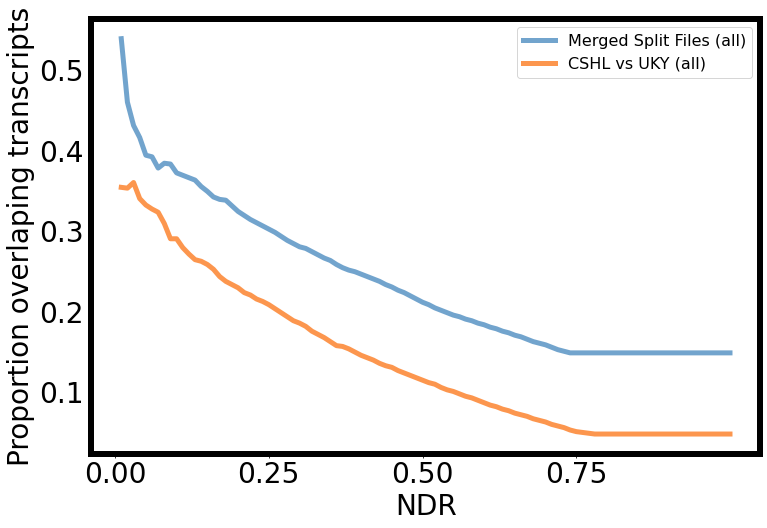

In [19]:
## Make plot comparing merged and CSHL vs UKY overlap at different thresholds.

plt.plot(list_ndr_2, list_prop_overlap, color='#377eb8', label="Merged Split Files (all)", linewidth=5, alpha=0.7)

plt.plot(list_ndr_2, list_prop_overlap_2, color='#fc6a03', label="CSHL vs UKY (all)", linewidth=5, alpha=0.7)

plt.xticks(np.arange(0, 1, step=0.25))
plt.xticks(np.arange(0, 1, step=0.25))
plt.xlabel('NDR')
plt.ylabel('Proportion overlaping transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.savefig('../../figures/02.discovery_stringency_comparison/ndr_gene_overlap_basic.png', dpi=300, transparent=True, bbox_inches="tight")
plt.show()

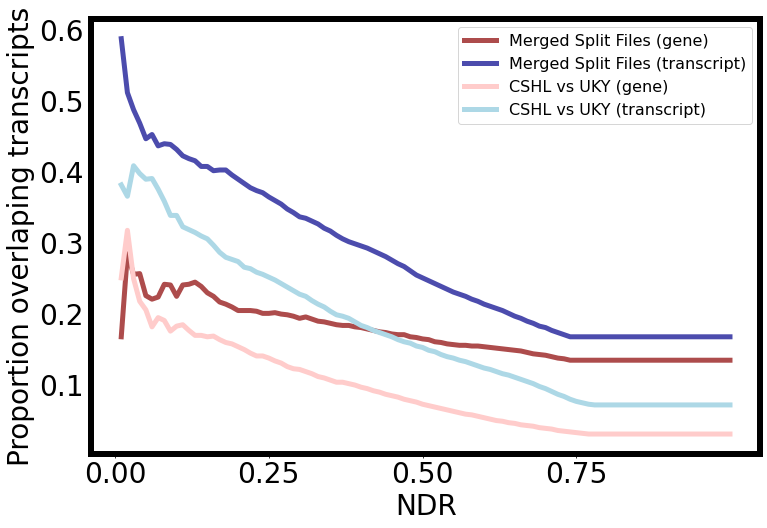

In [20]:
## Make plot

plt.plot(list_ndr_2, list_prop_overlap_gene, color='#8b0000', label="Merged Split Files (gene)", linewidth=5, alpha=0.7)
plt.plot(list_ndr_2, list_prop_overlap_transcript, color='#00008B', label="Merged Split Files (transcript)", linewidth=5, alpha=0.7)


plt.plot(list_ndr_2, list_prop_overlap_2_gene, color='#FFCCCB', label="CSHL vs UKY (gene)", linewidth=5, alpha=1)
plt.plot(list_ndr_2, list_prop_overlap_2_transcript, color='#ADD8E6', label="CSHL vs UKY (transcript)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 1, step=0.25))
plt.xticks(np.arange(0, 1, step=0.25))
plt.xlabel('NDR')
plt.ylabel('Proportion overlaping transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.savefig('../../figures/02.discovery_stringency_comparison/ndr_gene_overlap_granular.png', dpi=300, transparent=True, bbox_inches="tight")
plt.show()

## Same analysis with Average CPM > 1 Threshold added

In [21]:
## Load counts data
df_counts_first = pd.read_csv("../../data/raw/merged_first_half_loose/bambu_discovery/counts_transcript.txt", sep="\t")
df_counts_second = pd.read_csv("../../data/raw/merged_second_half_loose/bambu_discovery/counts_transcript.txt", sep="\t")

df_counts_cshl = pd.read_csv("../../data/raw/cshl_aged_loose/bambu_discovery/counts_transcript.txt", sep="\t")
df_counts_uky = pd.read_csv("../../data/raw/uky_aged_loose/bambu_discovery/counts_transcript.txt", sep="\t")

In [22]:
## Fix column names
df_counts_first = fix_column_names(df_counts_first, is_gene=False)
df_counts_second = fix_column_names(df_counts_second, is_gene=False)

df_counts_cshl = fix_column_names(df_counts_cshl, is_gene=False)
df_counts_uky = fix_column_names(df_counts_uky, is_gene=False)

In [23]:
## Calculate total counts
df_counts_first["total_counts"] = df_counts_first[df_counts_first.columns[2:6].tolist()].sum(axis=1)
df_counts_second["total_counts"] = df_counts_second[df_counts_second.columns[2:6].tolist()].sum(axis=1)

df_counts_cshl["total_counts"] = df_counts_cshl[df_counts_cshl.columns[2:6].tolist()].sum(axis=1)
df_counts_uky["total_counts"] = df_counts_uky[df_counts_uky.columns[2:6].tolist()].sum(axis=1)

In [24]:
## Calculate CPM and drop count columns
df_counts_first = calculate_cpm(df_counts_first, is_gene=False)
df_counts_second = calculate_cpm(df_counts_second, is_gene=False)

df_counts_cshl = calculate_cpm(df_counts_cshl, is_gene=False)
df_counts_uky = calculate_cpm(df_counts_uky, is_gene=False)


df_counts_first = df_counts_first[df_counts_first.columns.drop(list(df_counts_first.filter(regex='counts')))]
df_counts_second = df_counts_second[df_counts_second.columns.drop(list(df_counts_second.filter(regex='counts')))]

df_counts_cshl = df_counts_cshl[df_counts_cshl.columns.drop(list(df_counts_cshl.filter(regex='counts')))]
df_counts_uky = df_counts_uky[df_counts_uky.columns.drop(list(df_counts_uky.filter(regex='counts')))]

In [25]:
df_cshl.shape

(41191, 5)

In [26]:
## Add CPM data to NDR dataframes
df_first_half_cpm = df_first_half.merge(df_counts_first, how="inner", on=["transcript_id", "gene_id"])
df_second_half_cpm= df_second_half.merge(df_counts_second, how="inner", on=["transcript_id", "gene_id"])

df_cshl_cpm = df_cshl.merge(df_counts_cshl, how="inner", on=["transcript_id", "gene_id"])
df_uky_cpm = df_uky.merge(df_counts_uky, how="inner", on=["transcript_id", "gene_id"])

In [27]:
df_cshl_cpm.head()

,transcript_id,20_bp_thresh,gene_id,read_count,NDR,PAM08265_1291_nanopore_CPM,PAM08004_356_nanopore_CPM,PAM05748_1271_nanopore_CPM,PAM08277_1304_nanopore_CPM,total_CPM
0,tx.1,Divergent,ENSG00000227232,44,0.141057,0.57,0.36,0.84,1.34,0.80
1,tx.2,Divergent,ENSG00000227232,29,0.300726,1.04,0.50,0.94,0.31,0.69
2,tx.33291,Divergent,gene.1937,2,0.640163,0.15,0.15,0.02,0.08,0.09
3,tx.3,Divergent,ENSG00000269981,2,0.717468,0.00,0.00,0.00,0.00,0.00
4,tx.4,Divergent,ENSG00000239906,3,0.706464,0.07,0.00,0.00,0.00,0.02


In [28]:
## Get percent overlap for each NDR threshold

list_ndr_2 = []
list_prop_overlap = []
list_prop_overlap_gene = []
list_prop_overlap_transcript = []

for i in range(100, 0, -1):
    
    j = i/100
    
    df_first = df_first_half_cpm.loc[df_first_half_cpm["NDR"] <= j].copy()
    df_second = df_second_half_cpm.loc[df_second_half_cpm["NDR"] <= j].copy()
    
    df_first = df_first.loc[df_first["total_CPM"] > 1].copy()
    df_second = df_second.loc[df_second["total_CPM"] > 1].copy()
    
    df_first_gene = df_first.loc[df_first["gene_id"].str.contains("gene.")].copy()
    df_first_transcripts = df_first.loc[~df_first["gene_id"].str.contains("gene.")].copy()
    
    df_second_gene = df_second.loc[df_second["gene_id"].str.contains("gene.")].copy()
    df_second_transcripts = df_second.loc[~df_second["gene_id"].str.contains("gene.")].copy()
    
    first_overlapping = df_first.loc[df_first["20_bp_thresh"] == "Overlaping"].shape[0]/df_first.shape[0]
    second_overlapping = df_second.loc[df_second["20_bp_thresh"] == "Overlaping"].shape[0]/df_second.shape[0]
    
    first_prop_overlapping_gene = df_first_gene.loc[df_first_gene["20_bp_thresh"] == "Overlaping"].shape[0]/df_first_gene.shape[0]
    second_prop_overlapping_gene = df_second_gene.loc[df_second_gene["20_bp_thresh"] == "Overlaping"].shape[0]/df_second_gene.shape[0]

    first_prop_overlapping_transcript = df_first_transcripts.loc[df_first_transcripts["20_bp_thresh"] == "Overlaping"].shape[0]/df_first_transcripts.shape[0]
    second_prop_overlapping_transcript = df_second_transcripts.loc[df_second_transcripts["20_bp_thresh"] == "Overlaping"].shape[0]/df_second_transcripts.shape[0]
    
    overlap_pro= round(((first_overlapping + second_overlapping)/2), 3)
    overlap_pro_gene = round(((first_prop_overlapping_gene + second_prop_overlapping_gene)/2), 3)
    overlap_pro_transcript = round(((first_prop_overlapping_transcript + second_prop_overlapping_transcript)/2), 3)
    
    list_ndr_2.append(j)
    list_prop_overlap.append(overlap_pro)
    list_prop_overlap_gene.append(overlap_pro_gene)
    list_prop_overlap_transcript.append(overlap_pro_transcript)

In [29]:
## Get percent overlap for each NDR threshold

list_ndr_2 = []
list_prop_overlap_2 = []
list_prop_overlap_2_gene = []
list_prop_overlap_2_transcript = []

for i in range(100, 0, -1):
    
    j = i/100
    
    df_cshl_2 = df_cshl_cpm.loc[df_cshl_cpm["NDR"] <= j].copy()
    df_uky_2 = df_uky_cpm.loc[df_uky_cpm["NDR"] <= j].copy()
    
    df_cshl_2 = df_cshl_2.loc[df_cshl_2["total_CPM"] > 1].copy()
    df_uky_2 = df_uky_2.loc[df_uky_2["total_CPM"] > 1].copy()
    
    df_cshl_2_gene = df_cshl_2.loc[df_cshl_2["gene_id"].str.contains("gene.")].copy()
    df_cshl_2_transcripts = df_cshl_2.loc[~df_cshl_2["gene_id"].str.contains("gene.")].copy()
    
    df_uky_2_gene = df_uky_2.loc[df_uky_2["gene_id"].str.contains("gene.")].copy()
    df_uky_2_transcripts = df_uky_2.loc[~df_uky_2["gene_id"].str.contains("gene.")].copy()
    
    cshl_prop_overlapping_2 = df_cshl_2.loc[df_cshl_2["20_bp_thresh"] == "Overlaping"].shape[0]/df_cshl_2.shape[0]
    uky_prop_overlapping_2 = df_uky_2.loc[df_uky_2["20_bp_thresh"] == "Overlaping"].shape[0]/df_uky_2.shape[0]
    
    cshl_prop_overlapping_2_gene = df_cshl_2_gene.loc[df_cshl_2_gene["20_bp_thresh"] == "Overlaping"].shape[0]/df_cshl_2_gene.shape[0]
    uky_prop_overlapping_2_gene = df_uky_2_gene.loc[df_uky_2_gene["20_bp_thresh"] == "Overlaping"].shape[0]/df_uky_2_gene.shape[0]

    cshl_prop_overlapping_2_transcript = df_cshl_2_transcripts.loc[df_cshl_2_transcripts["20_bp_thresh"] == "Overlaping"].shape[0]/df_cshl_2_transcripts.shape[0]
    uky_prop_overlapping_2_transcript = df_uky_2_transcripts.loc[df_uky_2_transcripts["20_bp_thresh"] == "Overlaping"].shape[0]/df_uky_2_transcripts.shape[0]
    
    overlap_pro_2 = round(((cshl_prop_overlapping_2 + uky_prop_overlapping_2)/2), 3)
    overlap_pro_2_gene = round(((cshl_prop_overlapping_2_gene + uky_prop_overlapping_2_gene)/2), 3)
    overlap_pro_2_transcript = round(((cshl_prop_overlapping_2_transcript + uky_prop_overlapping_2_transcript)/2), 3)
    
    list_ndr_2.append(j)
    list_prop_overlap_2.append(overlap_pro_2)
    list_prop_overlap_2_gene.append(overlap_pro_2_gene)
    list_prop_overlap_2_transcript.append(overlap_pro_2_transcript)

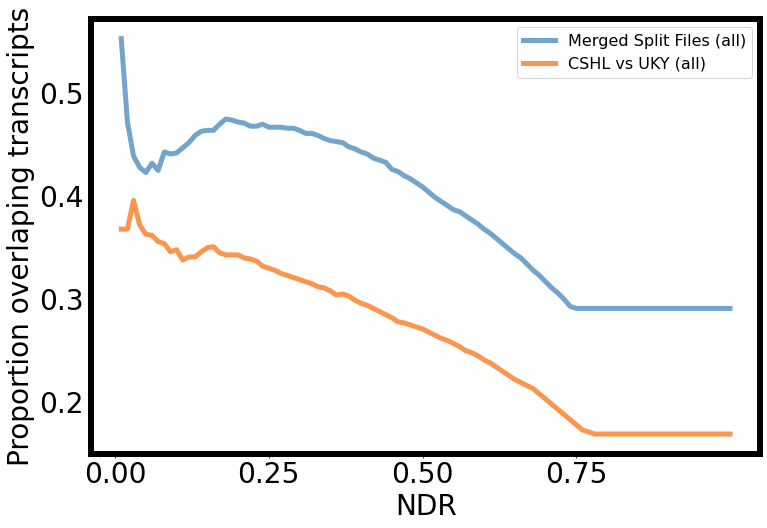

In [30]:
## Make plot comparing merged and CSHL vs UKY overlap at different thresholds.

plt.plot(list_ndr_2, list_prop_overlap, color='#377eb8', label="Merged Split Files (all)", linewidth=5, alpha=0.7)

plt.plot(list_ndr_2, list_prop_overlap_2, color='#fc6a03', label="CSHL vs UKY (all)", linewidth=5, alpha=0.7)

plt.xticks(np.arange(0, 1, step=0.25))
plt.xticks(np.arange(0, 1, step=0.25))
plt.xlabel('NDR')
plt.ylabel('Proportion overlaping transcripts')
plt.legend(loc="upper right", fontsize=16)
#plt.savefig('../../figures/02.discovery_stringency_comparison/ndr_gene_overlap_basic.png', dpi=300, transparent=True, bbox_inches="tight")
plt.show()

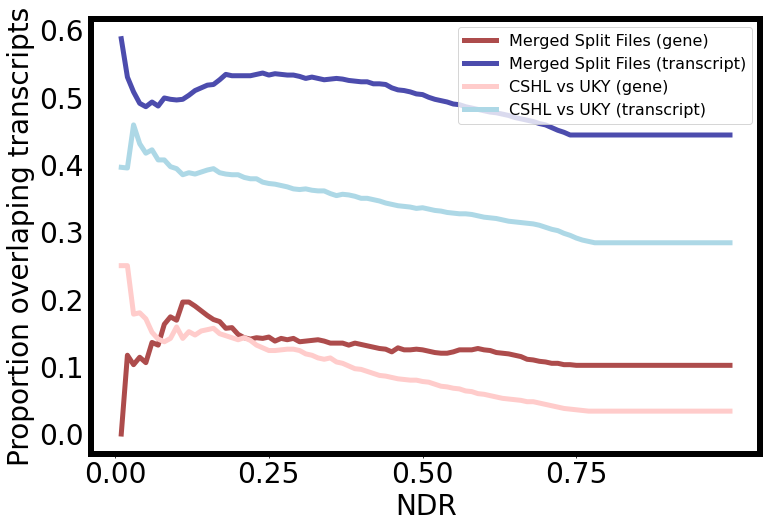

In [31]:
## Make plot

plt.plot(list_ndr_2, list_prop_overlap_gene, color='#8b0000', label="Merged Split Files (gene)", linewidth=5, alpha=0.7)
plt.plot(list_ndr_2, list_prop_overlap_transcript, color='#00008B', label="Merged Split Files (transcript)", linewidth=5, alpha=0.7)


plt.plot(list_ndr_2, list_prop_overlap_2_gene, color='#FFCCCB', label="CSHL vs UKY (gene)", linewidth=5, alpha=1)
plt.plot(list_ndr_2, list_prop_overlap_2_transcript, color='#ADD8E6', label="CSHL vs UKY (transcript)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 1, step=0.25))
plt.xticks(np.arange(0, 1, step=0.25))
plt.xlabel('NDR')
plt.ylabel('Proportion overlaping transcripts')
plt.legend(loc="upper right", fontsize=16)
#plt.savefig('../../figures/02.discovery_stringency_comparison/ndr_gene_overlap_granular.png', dpi=300, transparent=True, bbox_inches="tight")
plt.show()

# Each Analysis

In [ ]:
## Get percent overlap for each NDR threshold

list_ndr_2 = []
list_prop_overlap = []
list_prop_overlap_gene = []
list_prop_overlap_transcript = []

for i in range(100, 0, -1):
    
    j = i/100
    
    df_first = df_first_half_cpm.loc[df_first_half_cpm["NDR"] <= j].copy()
    df_second = df_second_half_cpm.loc[df_second_half_cpm["NDR"] <= j].copy()
    
    df_first = df_first[(df_first[df_first.columns[5:]]>1).sum(axis=1)>=5].copy()
    df_second = df_second[(df_second[df_second.columns[5:]]>1).sum(axis=1)>=5].copy()
    
    df_first_gene = df_first.loc[df_first["gene_id"].str.contains("gene.")].copy()
    df_first_transcripts = df_first.loc[~df_first["gene_id"].str.contains("gene.")].copy()
    
    df_second_gene = df_second.loc[df_second["gene_id"].str.contains("gene.")].copy()
    df_second_transcripts = df_second.loc[~df_second["gene_id"].str.contains("gene.")].copy()
    
    first_overlapping = df_first.loc[df_first["20_bp_thresh"] == "Overlaping"].shape[0]/df_first.shape[0]
    second_overlapping = df_second.loc[df_second["20_bp_thresh"] == "Overlaping"].shape[0]/df_second.shape[0]
    
    first_prop_overlapping_gene = df_first_gene.loc[df_first_gene["20_bp_thresh"] == "Overlaping"].shape[0]/df_first_gene.shape[0]
    second_prop_overlapping_gene = df_second_gene.loc[df_second_gene["20_bp_thresh"] == "Overlaping"].shape[0]/df_second_gene.shape[0]

    first_prop_overlapping_transcript = df_first_transcripts.loc[df_first_transcripts["20_bp_thresh"] == "Overlaping"].shape[0]/df_first_transcripts.shape[0]
    second_prop_overlapping_transcript = df_second_transcripts.loc[df_second_transcripts["20_bp_thresh"] == "Overlaping"].shape[0]/df_second_transcripts.shape[0]
    
    overlap_pro= round(((first_overlapping + second_overlapping)/2), 3)
    overlap_pro_gene = round(((first_prop_overlapping_gene + second_prop_overlapping_gene)/2), 3)
    overlap_pro_transcript = round(((first_prop_overlapping_transcript + second_prop_overlapping_transcript)/2), 3)
    
    list_ndr_2.append(j)
    list_prop_overlap.append(overlap_pro)
    list_prop_overlap_gene.append(overlap_pro_gene)
    list_prop_overlap_transcript.append(overlap_pro_transcript)

In [ ]:
## Get percent overlap for each NDR threshold

list_ndr_2 = []
list_prop_overlap_2 = []
list_prop_overlap_2_gene = []
list_prop_overlap_2_transcript = []

for i in range(100, 0, -1):
    
    j = i/100
    
    df_cshl_2 = df_cshl_cpm.loc[df_cshl_cpm["NDR"] <= j].copy()
    df_uky_2 = df_uky_cpm.loc[df_uky_cpm["NDR"] <= j].copy()
    
    df_cshl_2 = df_cshl_2[(df_cshl_2[df_cshl_2.columns[5:]]>1).sum(axis=1)>=5].copy()
    df_uky_2 = df_uky_2[(df_uky_2[df_uky_2.columns[5:]]>1).sum(axis=1)>=5].copy()
    
    df_cshl_2_gene = df_cshl_2.loc[df_cshl_2["gene_id"].str.contains("gene.")].copy()
    df_cshl_2_transcripts = df_cshl_2.loc[~df_cshl_2["gene_id"].str.contains("gene.")].copy()
    
    df_uky_2_gene = df_uky_2.loc[df_uky_2["gene_id"].str.contains("gene.")].copy()
    df_uky_2_transcripts = df_uky_2.loc[~df_uky_2["gene_id"].str.contains("gene.")].copy()
    
    cshl_prop_overlapping_2 = df_cshl_2.loc[df_cshl_2["20_bp_thresh"] == "Overlaping"].shape[0]/df_cshl_2.shape[0]
    uky_prop_overlapping_2 = df_uky_2.loc[df_uky_2["20_bp_thresh"] == "Overlaping"].shape[0]/df_uky_2.shape[0]
    
    cshl_prop_overlapping_2_gene = df_cshl_2_gene.loc[df_cshl_2_gene["20_bp_thresh"] == "Overlaping"].shape[0]/df_cshl_2_gene.shape[0]
    uky_prop_overlapping_2_gene = df_uky_2_gene.loc[df_uky_2_gene["20_bp_thresh"] == "Overlaping"].shape[0]/df_uky_2_gene.shape[0]

    cshl_prop_overlapping_2_transcript = df_cshl_2_transcripts.loc[df_cshl_2_transcripts["20_bp_thresh"] == "Overlaping"].shape[0]/df_cshl_2_transcripts.shape[0]
    uky_prop_overlapping_2_transcript = df_uky_2_transcripts.loc[df_uky_2_transcripts["20_bp_thresh"] == "Overlaping"].shape[0]/df_uky_2_transcripts.shape[0]
    
    overlap_pro_2 = round(((cshl_prop_overlapping_2 + uky_prop_overlapping_2)/2), 3)
    overlap_pro_2_gene = round(((cshl_prop_overlapping_2_gene + uky_prop_overlapping_2_gene)/2), 3)
    overlap_pro_2_transcript = round(((cshl_prop_overlapping_2_transcript + uky_prop_overlapping_2_transcript)/2), 3)
    
    list_ndr_2.append(j)
    list_prop_overlap_2.append(overlap_pro_2)
    list_prop_overlap_2_gene.append(overlap_pro_2_gene)
    list_prop_overlap_2_transcript.append(overlap_pro_2_transcript)

In [ ]:
## Make plot comparing merged and CSHL vs UKY overlap at different thresholds.

plt.plot(list_ndr_2, list_prop_overlap, color='#377eb8', label="Merged Split Files (all)", linewidth=5, alpha=0.7)

plt.plot(list_ndr_2, list_prop_overlap_2, color='#fc6a03', label="CSHL vs UKY (all)", linewidth=5, alpha=0.7)

plt.xticks(np.arange(0, 1, step=0.25))
plt.xticks(np.arange(0, 1, step=0.25))
plt.xlabel('NDR')
plt.ylabel('Proportion overlaping transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.savefig('../../figures/02.discovery_stringency_comparison/ndr_gene_overlap_basic.png', dpi=300, transparent=True, bbox_inches="tight")
plt.show()